# **Learning Moore machines from Input-Output traces: A Proof of Concept (PoC) project**

> Ce projet a pour but d'examiner et critiquer l'algorithme **MooreMI**, introduit par Giantamidis et al. (2021), afin de valider sa reproductibilité et son efficience dans l'identification des machines de Moore **déterministes** et **complètes**, à partir de **traces entrées-sorties**. On souhaite confirmer le résulat théorique clé de l'article: étant donnée un ensemble de traces entrées-sorties d'une machine de Moore (l'originale), satisfaisant la condition de l'échantillon caractéristique (**Characteristic Sample Requirement (CSR)**), l'algorithme MooreMI peut apprendre une machine de Moore **minimale équivalente (isomorphique)** à l'originale.

**Reférence du papier:**  
Giantamidis, G., Tripakis, S., & Basagiannis, S. (2021). *Learning Moore machines from input–output traces.* International Journal on Software Tools for Technology Transfer, 23(1), 1–29.  
[https://doi.org/10.1007/s10009-019-00544-0](https://doi.org/10.1007/s10009-019-00544-0)



# 1. Introduction au problème et à la modélisation.

Dans le contexte actuel de l’ingénierie des systèmes et de la vérification formelle, la **synthèse et l’apprentissage de machines de Moore** à partir de **traces d’entrées-sorties** suscitent un intérêt croissant. Les machines de Moore sont des automates finis augmentés d’une fonction de sortie, permettant de décrire le comportement d’un système réactif. 

>L’enjeu est de partir de données (traces) représentant l’évolution d’un système face à un ensemble d’entrées, afin d’en reconstruire une machine de Moore équivalente (ou approchante) au système d’origine, sans disposer d’une description interne ou formelle de ce dernier.

L’article en question introduit un algorithme, **MooreMI**, visant à apprendre une machine de Moore déterministe et complète à partir d’un ensemble de traces entrées-sorties. L’un des points clés est la condition de l’**échantillon caractéristique (Characteristic Sample Requirement, CSR)**. Si les traces fournies satisfont cette condition, MooreMI garantit l’identification, dans la limite, de la machine cible minimale équivalente. Le résultat théorique est fort, mais sa reproductibilité et ses performances pratiques méritent d’être évaluées.

Le présent projet de preuve de concept (PoC) s’est donné pour objectif **d’évaluer empiriquement la reproductibilité et l’efficacité de MooreMI**. Plus précisément, nous avons :

- **Implémenté MooreMI conformément aux indications de l’article.**
- **Construit 3 machines de Moore représentatives (de différentes tailles, alphabets et complexités).**
- **Généré des ensembles de traces, dont certains incluent un échantillon caractéristique, afin de tester la capacité de MooreMI à retrouver la machine originale.**
- **Comparé la machine apprise à la machine cible, pour juger de l’identification à la limite.**
- **Analysé les résultats et identifié d’éventuelles limites ou points d’amélioration (qualité de l’échantillon, complexité, etc.).**


# 2. Critères pour évaluer une solution

1. **Exactitude de l’identification** :  
   Le but principal de MooreMI est d’identifier une machine de Moore minimalement équivalente à celle dont proviennent les traces. Nous évaluons donc si la machine apprise par MooreMI est :
   - Complète et déterministe.
   - Minimale (pas d’états redondants).
   - Équivalente (isomorphe) à la machine cible, c’est-à-dire produisant les mêmes sorties pour toutes les séquences d’entrées possibles.

2. **Respect de la condition CSR (Characteristic Sample Requirement)** :  
   L’article souligne que si l’échantillon de traces satisfait la condition CSR, MooreMI garantit l’identification in the limit. Nous vérifierons si, lorsque notre ensemble de traces respecte la CSR, la machine apprise est effectivement équivalente à la machine cible. À défaut, cela pourrait révéler un problème dans l’implémentation, la qualité des traces ou l’interprétation de la CSR.

3. **Robustesse face à la complexité de la machine** :  
   Nous testons MooreMI sur différentes machines, de tailles et de complexités variées (nombre d’états, d’entrées, de sorties, structure plus ou moins cyclique). Le critère est de vérifier si l’algorithme parvient à reconstruire correctement la machine cible dans des cas simples et, a minima, à offrir un résultat cohérent ou interprétable même sur des cas plus complexes.


# 3. Aperçu du dataset (Ensemble de traces)

## 3.1. Machines testées :

- **Machine A (cas intermédiaire)** :  
  - Nombre d’états : 5  
  - Alphabet d’entrée : 3 symboles (ex. {a, b, c})  
  - Alphabet de sortie : codé en pseudo-binaire sur 2 bits (ex. {"00","01","10"})
  
  Les sorties, déjà codées en binaire, facilitent théoriquement la tâche, mais la structure interne plus complexe met davantage MooreMI au défi. Elle représente un cas intermédiaire, ni trivial ni aussi ardu que la dernière machine.

- **Machine B (cas simple)** :  
  - Nombre d’états : 3  
  - Alphabet d’entrée : 2 symboles (ex. {a, b})  
  - Alphabet de sortie : 2 symboles (ex. {x, y})
  
  Elle sert de test de base pour vérifier que MooreMI identifie rapidement et sans ambiguïté la machine cible lorsque les conditions sont favorables.

- **Machine C (cas complexe)** :  
  - Nombre d’états : 7  
  - Alphabet d’entrée : 3 symboles (ex. {a, b, c})  
  - Alphabet de sortie : 3 symboles (ex. {x, y, z})
  
  Avec plus d’états et une structure interne plus riche, elle comporte potentiellement plus de chemins, de cycles, et d’ambiguïtés. Cette machine teste la robustesse de MooreMI dans un scénario moins favorable, où l’identification peut se révéler plus difficile.



In [1]:
from graphviz import Digraph

class MooreMachine:
    def __init__(self, states, input_alphabet, output_alphabet, outputs, transitions, initial_state):
        self.states = states
        self.input_alphabet = input_alphabet
        self.output_alphabet = output_alphabet
        self.outputs = outputs
        self.transitions = transitions
        self.initial_state = initial_state
        
        self._validate_machine()
        
    def _validate_machine(self):
        # Vérification basique : déterminisme, complétion, sorties définies
        for s in self.states:
            if s not in self.outputs:
                raise ValueError(f"L'état {s} n'a pas de sortie définie.")
            if s not in self.transitions:
                raise ValueError(f"L'état {s} n'a pas de transitions définies.")
            for inp in self.input_alphabet:
                if inp not in self.transitions[s]:
                    raise ValueError(f"L'état {s} n'a pas de transition pour l'entrée {inp}.")
        
    def display_text(self):
        print("Machine de Moore :")
        print("États :", self.states)
        print("Entrées :", self.input_alphabet)
        print("Sorties :", self.output_alphabet)
        print("\nSortie par état :")
        for s in self.states:
            print(f"État {s} -> sortie {self.outputs[s]}")
        
        print("\nTransitions :")
        for s in self.states:
            for inp in self.input_alphabet:
                print(f"({s}, {inp}) -> {self.transitions[s][inp]}")

    def visualize(self, filename='machine', format='png'):
        dot = Digraph(comment='Moore Machine', format=format)
        dot.attr(rankdir='LR')
        
        dot.node('init', shape='point', style='invis')
        
        for s in self.states:
            label = f"{s}\\noutput={self.outputs[s]}"
            dot.node(s, label=label, shape="ellipse")
        
        dot.edge('init', self.initial_state)
        
        for s in self.states:
            for inp in self.input_alphabet:
                next_s = self.transitions[s][inp]
                dot.edge(s, next_s, label=inp)
        
        dot.render(filename, view=False)
        return dot

    def minimize(self):
        """
        Minimise la machine en suivant un algorithme inspiré de la minimisation d'automates.
        Pour les machines de Moore, on partitionne les états selon leur sortie, puis on affine
        jusqu'à stabilité.
        
        Cet algorithme garantit qu'à la fin, la machine est minimale.
        """
        # Initialisation de la partition : groupe les états par leur sortie
        partition = {}
        for s in self.states:
            out = self.outputs[s]
            partition.setdefault(out, []).append(s)
        
        # liste des blocs
        blocks = list(partition.values())
        
        stable = False
        while not stable:
            stable = True
            new_blocks = []
            for block in blocks:
                # On tente de raffiner ce block
                refined = self._refine_block(block, blocks)
                if len(refined) > 1:
                    # Le bloc a été raffiné en plusieurs blocs
                    stable = False
                    new_blocks.extend(refined)
                else:
                    new_blocks.extend(refined)
            blocks = new_blocks
        
        # Chaque bloc représente désormais un état minimal
        # On construit la machine minimale
        new_states = [f"B{i}" for i in range(len(blocks))]
        
        # Map from old_state to new_state
        state_map = {}
        for i, block in enumerate(blocks):
            for st in block:
                state_map[st] = new_states[i]
        
        # Sortie de chaque bloc = sortie de n'importe quel état du bloc
        new_outputs = {}
        for i, block in enumerate(blocks):
            # Tous les états du bloc ont la même classe de comportement,
            # ils devraient avoir la même sortie (sinon ils auraient été séparés)
            new_outputs[new_states[i]] = self.outputs[block[0]]
        
        # Transitions
        new_transitions = {}
        for i, block in enumerate(blocks):
            rep_state = block[0]
            new_transitions[new_states[i]] = {}
            for inp in self.input_alphabet:
                target = self.transitions[rep_state][inp]
                new_transitions[new_states[i]][inp] = state_map[target]
        
        # État initial
        new_initial = state_map[self.initial_state]
        
        # Mise à jour de la machine
        self.states = new_states
        self.outputs = new_outputs
        self.transitions = new_transitions
        self.initial_state = new_initial

    def _refine_block(self, block, blocks):
        """
        Tente de raffiner un bloc selon les transitions.
        Deux états du bloc sont distincts s'ils ne mènent pas vers les mêmes blocs pour un même symbole
        d'entrée. On crée une clé de raffinement basée sur (sortie des transitions).
        """
        if len(block) <= 1:
            return [block]
        
        # Indexation des blocs
        block_map = {}
        for i, b in enumerate(blocks):
            for st in b:
                block_map[st] = i
        
        # Création de clés pour chaque état
        signature_map = {}
        for s in block:
            # Signature = tuple du bloc des états suivants pour chaque entrée + sortie
            sig = []
            for inp in self.input_alphabet:
                next_s = self.transitions[s][inp]
                sig.append(block_map[next_s])
            # On ajoute la sortie (déjà utilisée au début, mais ici tous partagent la même sortie)
            # Toutefois, la sortie ne différencie plus au sein du bloc initial
            signature = tuple(sig)
            signature_map.setdefault(signature, []).append(s)
        
        return list(signature_map.values())

### Création et visualisation de la machine A

Machine de Moore :
États : ['B0', 'B1', 'B2', 'B3', 'B4']
Entrées : ['a', 'b', 'c']
Sorties : ['00', '01', '10']

Sortie par état :
État B0 -> sortie 00
État B1 -> sortie 00
État B2 -> sortie 00
État B3 -> sortie 01
État B4 -> sortie 10

Transitions :
(B0, a) -> B1
(B0, b) -> B2
(B0, c) -> B3
(B1, a) -> B0
(B1, b) -> B4
(B1, c) -> B2
(B2, a) -> B3
(B2, b) -> B1
(B2, c) -> B4
(B3, a) -> B4
(B3, b) -> B3
(B3, c) -> B0
(B4, a) -> B2
(B4, b) -> B0
(B4, c) -> B1


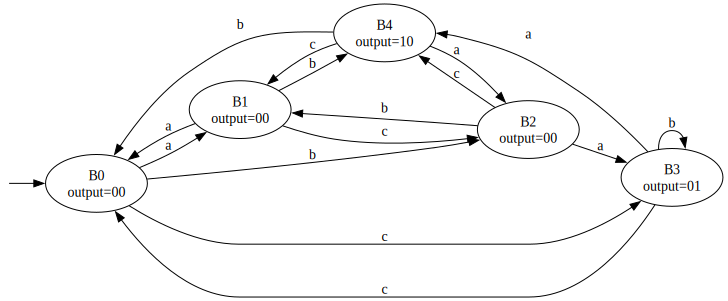

In [2]:
# Créons la machine A.

states_A = [f"q{i}" for i in range(5)]
input_alphabet_A = ["a", "b", "c"]
output_alphabet_A = ["00","01","10"]

# Pour assurer la minimalité finale, on va commencer par une machine potentiellement non minimale,
# puis la minimiser. Cette machine est construite de manière un peu redondante, puis minimisée.
# On crée des groupes d'états ayant initialement la même sortie, mais arrangés de sorte que
# la minimisation sépare ceux qui doivent l'être, et fusionne ceux qui sont équivalents.

# Idée : q0, q1, q2 partagent des comportements proches, q3, q4 un autre, q5 un autre etc.

outputs_A = {
    "q0": "00",  # au lieu de "x"
    "q1": "00",  # au lieu de "x"
    "q2": "00",  # au lieu de "x"
    "q3": "01",  # au lieu de "y"
    "q4": "10"   # au lieu de "z"
}

transitions_A = {
    "q0": {"a": "q1", "b": "q2", "c": "q3"},
    "q1": {"a": "q0", "b": "q4", "c": "q2"},
    "q2": {"a": "q3", "b": "q1", "c": "q4"},
    "q3": {"a": "q4", "b": "q3", "c": "q0"},
    "q4": {"a": "q2", "b": "q0", "c": "q1"}
}

initial_state = "q0"

machine_A = MooreMachine(
    states=states_A,
    input_alphabet=input_alphabet_A,
    output_alphabet=output_alphabet_A,
    outputs=outputs_A,
    transitions=transitions_A,
    initial_state=initial_state
)

# Minimisation interne de la machine
machine_A.minimize()

# Affichage textuel et graphique pour vérifier le résultat final
machine_A.display_text()

machine_A.visualize()

### Création et visualisation de la machine B

Machine de Moore :
États : ['B0', 'B1', 'B2']
Entrées : ['a', 'b']
Sorties : ['x', 'y']

Sortie par état :
État B0 -> sortie x
État B1 -> sortie x
État B2 -> sortie y

Transitions :
(B0, a) -> B1
(B0, b) -> B2
(B1, a) -> B2
(B1, b) -> B0
(B2, a) -> B0
(B2, b) -> B1


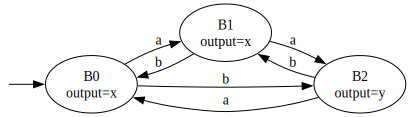

In [3]:
input_alphabet_B = ["a", "b"]

output_alphabet_B = ["x", "y"]

outputs_B = {
    "q0": "x",
    "q1": "x",
    "q2": "y"
}

transitions_B = {
    "q0": {"a": "q1", "b": "q2"},
    "q1": {"a": "q2", "b": "q0"},
    "q2": {"a": "q0", "b": "q1"}
}

machine_B = MooreMachine(
    states=["q0", "q1", "q2"],
    input_alphabet=input_alphabet_B,
    output_alphabet=output_alphabet_B,
    outputs=outputs_B,
    transitions=transitions_B,
    initial_state="q0"
)

machine_B.minimize()

machine_B.display_text()

machine_B.visualize()

### Création et visualisation de la machine C

Machine de Moore :
États : ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6']
Entrées : ['a', 'b', 'c']
Sorties : ['x', 'y', 'z']

Sortie par état :
État B0 -> sortie x
État B1 -> sortie x
État B2 -> sortie x
État B3 -> sortie y
État B4 -> sortie y
État B5 -> sortie z
État B6 -> sortie z

Transitions :
(B0, a) -> B2
(B0, b) -> B1
(B0, c) -> B3
(B1, a) -> B0
(B1, b) -> B2
(B1, c) -> B3
(B2, a) -> B1
(B2, b) -> B0
(B2, c) -> B4
(B3, a) -> B4
(B3, b) -> B3
(B3, c) -> B5
(B4, a) -> B3
(B4, b) -> B5
(B4, c) -> B6
(B5, a) -> B6
(B5, b) -> B5
(B5, c) -> B1
(B6, a) -> B1
(B6, b) -> B6
(B6, c) -> B4


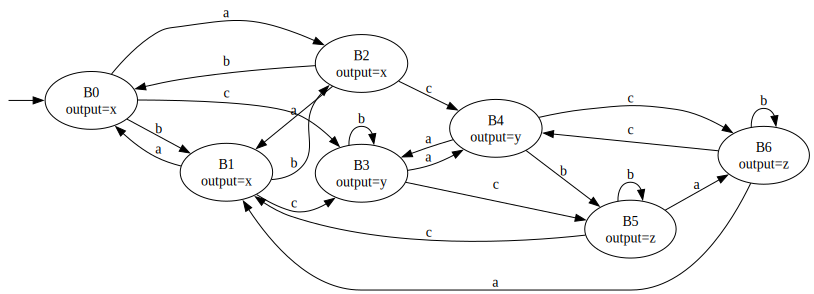

In [4]:
input_alphabet_C = ["a", "b", "c"]
    
output_alphabet_C = ["x", "y", "z"]

outputs_C = {
    "q0": "x",
    "q1": "x",
    "q2": "x",
    "q3": "y",
    "q4": "y",
    "q5": "z",
    "q6": "z"
}

transitions_C = {
    "q0": {"a": "q1", "b": "q2", "c": "q3"},
    "q1": {"a": "q2", "b": "q0", "c": "q4"},
    "q2": {"a": "q0", "b": "q1", "c": "q3"},
    "q3": {"a": "q4", "b": "q3", "c": "q5"},
    "q4": {"a": "q3", "b": "q5", "c": "q6"},
    "q5": {"a": "q6", "b": "q5", "c": "q2"},
    "q6": {"a": "q2", "b": "q6", "c": "q4"}
}

machine_C = MooreMachine(
    states=["q0", "q1", "q2", "q3", "q4", "q5", "q6"],
    input_alphabet=input_alphabet_C,
    output_alphabet=output_alphabet_C,
    outputs=outputs_C,
    transitions=transitions_C,
    initial_state="q0"
)   

machine_C.minimize()

machine_C.display_text()

machine_C.visualize()

## 3.2. Génération des traces :
Pour chacune de ces machines, nous avons :
1. Généré un **échantillon caractéristique (Characteristic Sample)**, combinant les "shortest prefixes" menant à chaque état avec les "minimum distinguishing suffixes (MDS)". Cet échantillon est censé garantir, en théorie, l’"identification in the limit".
2. Ajouté des traces supplémentaires aléatoires, pour enrichir l’ensemble et voir si la présence de données additionnelles influe sur la qualité de l’apprentissage.

Ainsi, pour chaque machine (A, B, C), nous avons produit un ensemble de traces entrées-sorties. Par exemple :
- **Pour Machine A** : Environ une trentaine de traces combinant l’échantillon caractéristique et des traces aléatoires.
- **Pour Machine B** : Un nombre similaire ou un peu plus important de traces, adapté à sa complexité.
- **Pour Machine C** : Un ensemble plus important de traces (plus de 40), reflétant la taille accrue de la machine et la nécessité d’un échantillon caractéristique plus riche.

Cet ensemble de traces sert de « dataset » pour MooreMI. Chaque trace est une suite d’entrées menant à une suite de sorties, depuis l’état initial. Les données sont structurées sous forme de tuples ((None, sortie_initiale), (entrée_1, sortie_après_entrée_1), …), permettant de reconstituer la séquence complète de sorties induites par les entrées successives.

In [5]:
from collections import deque
import itertools
import random


class TraceGenerator:
    def __init__(self, machine):
        self.machine = machine
        
    def shortest_prefixes(self):
        """
        Trouve pour chaque état le plus court préfixe d’entrée le menant depuis l’état initial.
        Retourne un dictionnaire {état: liste d’entrées}.
        """
        # BFS
        prefix_map = {self.machine.initial_state: []}
        queue = deque([self.machine.initial_state])
        visited = {self.machine.initial_state}
        
        while queue:
            s = queue.popleft()
            for inp in self.machine.input_alphabet:
                next_s = self.machine.transitions[s][inp]
                if next_s not in visited:
                    visited.add(next_s)
                    prefix_map[next_s] = prefix_map[s] + [inp]
                    queue.append(next_s)

        return prefix_map
    
    def produce_io_trace(self, input_sequence):
        """
        À partir d’une séquence d’entrées, produit la séquence de sorties correspondante.
        Retourne une liste de tuples (entrée, sortie) pour chaque étape.
        """
        current_state = self.machine.initial_state
        io_trace = [(None, self.machine.outputs[current_state])]  # sortie initiale
        # (On inclut ici la sortie de l’état initial avant la première entrée)
        
        for inp in input_sequence:
            # Appliquer l’entrée
            current_state = self.machine.transitions[current_state][inp]
            out = self.machine.outputs[current_state]
            io_trace.append((inp, out))
        
        return io_trace
    
    def find_MDS(self):
        """
        Trouve des minimum distinguishing suffixes (MDS) pour distinguer tous les états entre eux.
        Méthode simplifiée : on compare les comportements de paires d’états, et on cherche une suffixe
        les différenciant.
        
        Algorithme :
        - On considère chaque paire (q_u, q_v)
        - On cherche un suffixe minimal (par BFS sur la longueur de suffixe) qui produit des sorties différentes
          lorsqu’on part de q_u et q_v.
        - On stocke ce suffixe dans un ensemble.
        
        Cette approche est inspirée des techniques standard d’inférence, même si elle est simplifiée.
        """
        states = self.machine.states
        MDS_set = set()
        
        # Pour chaque paire d’états, trouver un suffixe les distinguant
        # S’il n’y a pas de tel suffixe, c’est qu’ils sont déjà équivalents (la machine est minimale, 
        # donc ils ne devraient pas être équivalents).
        
        for i, q_u in enumerate(states):
            for q_v in states[i+1:]:
                # BFS sur les suffixes
                if self.machine.outputs[q_u] != self.machine.outputs[q_v]:
                    # Dès le départ, sans entrée, ils sont déjà différents
                    # suffixe vide les distingue, pas besoin de suffixe non vide
                    # mais pour un MDS, on va considérer un suffixe vide comme trivial
                    MDS_set.add(())  # suffixe vide
                    continue
                
                # Sinon, on essaie des suffixes de plus en plus longs
                # On effectue un BFS sur l’espace des suffixes (on limite la profondeur)
                # Dans un monde réel, la machine est finie et minimalité assure la fin.
                
                found = False
                queue = deque([()])
                
                visited = set([()])
                
                while queue and not found:
                    suffix = queue.popleft()
                    
                    # Appliquer le suffixe sur q_u et q_v
                    out_u = self.apply_suffix(q_u, suffix)
                    out_v = self.apply_suffix(q_v, suffix)
                    
                    if out_u != out_v:
                        # Ce suffixe les différencie
                        MDS_set.add(suffix)
                        found = True
                        break
                    
                    # Sinon, étendre le suffixe
                    for inp in self.machine.input_alphabet:
                        new_suf = suffix + (inp,)
                        if new_suf not in visited:
                            visited.add(new_suf)
                            queue.append(new_suf)
                
                # Si on ne trouve rien, c’est que les états ne sont pas distinguables
                # Mais la machine est minimale, donc on devrait toujours trouver quelque chose.
        
        return MDS_set
    
    def apply_suffix(self, state, suffix):
        """
        Applique un suffixe (suite d'entrées) à partir d'un état donné, 
        retourne la séquence de sorties générée.
        Pour un MDS, on s’intéresse à la sortie finale ou la séquence complète ?
        Typiquement, on compare la sortie finale induite par le suffixe.
        Mais pour plus de prudence, comparons la séquence complète.
        
        Retourne la séquence de sorties produite en lisant le suffixe.
        """
        current_state = state
        outputs = [self.machine.outputs[current_state]]
        for inp in suffix:
            current_state = self.machine.transitions[current_state][inp]
            outputs.append(self.machine.outputs[current_state])
        # On retourne la séquence complète de sorties
        # Pour distinguer deux états, si les séquences complètes de sorties diffèrent, c'est suffisant
        return tuple(outputs)

    def build_characteristic_sample(self):
        """
        Construit un échantillon caractéristique.
        Approche simplifiée :
        - On obtient Sp(M) = shortest prefixes menant à chaque état.
        - On obtient un ensemble de MDS.
        
        L’échantillon caractéristique consiste en toutes les combinaisons des shortest prefixes avec
        les MDS. En effet, il faut distinguer chaque état accessible par un shortest prefix.
        
        On combine donc chaque shortest prefix avec chaque MDS (en les concaténant).
        """
        prefix_map = self.shortest_prefixes()
        MDS_set = self.find_MDS()
        
        # Construction de l’échantillon
        # Sp(M) contient un préfixe pour chaque état
        # MDS_set contient des suffixes distinguant potentiellement des états
        # L’échantillon caractéristique = { p + s | p ∈ Sp(M), s ∈ MDS_set }
        
        # Note : Le suffixe vide est possible, on inclut donc aussi p tout seul.
        
        characteristic_sample = set()
        for st, pref in prefix_map.items():
            for mds in MDS_set:
                # Combiner le préfixe et le suffixe
                combined = pref + list(mds)
                characteristic_sample.add(tuple(combined))
        
        # On retourne un set de tuples représentant les séquences d'entrée
        return characteristic_sample, prefix_map, MDS_set
    
    def add_additional_traces(self, count=20, max_length=10):
        """
        Ajoute des traces supplémentaires au training set, choisies aléatoirement,
        pour couvrir plus de chemins, y compris des cycles.
        
        Cela n’est pas strictement dans l’article, mais l’article suggère d’avoir un ensemble riche.
        On prend l’initiative d’ajouter quelques traces randomisées.
        
        :param count: Nombre de traces supplémentaires
        :param max_length: Longueur max de ces traces
        """
        import random
        additional = set()
        for _ in range(count):
            length = random.randint(1, max_length)
            trace = tuple(random.choice(self.machine.input_alphabet) for _ in range(length))
            additional.add(trace)
        return additional

    def generate_training_set(self):
        # Créer l’échantillon caractéristique
        characteristic_sample, prefix_map, MDS_set = self.build_characteristic_sample()
        
        # Ajouter des traces supplémentaires
        additional_traces = self.add_additional_traces()
        
        # Union
        training_input_set = characteristic_sample.union(additional_traces)
        
        # Convertir en (entrée, sortie) -> listes de tuples (inp, out)
        io_traces = []
        for inp_seq in training_input_set:
            io_trace = self.produce_io_trace(inp_seq)
            io_traces.append(io_trace)
        
        return io_traces, prefix_map, MDS_set


### Génération de traces de la machine A

In [6]:
# Nous allons générer les traces.

trace_gen_A = TraceGenerator(machine_A)
io_traces_A, prefix_map_A, MDS_set_A = trace_gen_A.generate_training_set()

# Afficher les informations
print("Nombre de traces générées :", len(io_traces_A))
print("Exemples de traces (entrée -> (entrée, sortie)) :")
for t in list(io_traces_A)[:5]:
    print(t)

Nombre de traces générées : 28
Exemples de traces (entrée -> (entrée, sortie)) :
[(None, '00'), ('a', '00'), ('a', '00')]
[(None, '00'), ('b', '00'), ('b', '00'), ('c', '00'), ('a', '01'), ('c', '00'), ('b', '00')]
[(None, '00'), ('c', '01'), ('a', '10'), ('b', '00'), ('c', '01'), ('b', '01')]
[(None, '00'), ('a', '00'), ('c', '00')]
[(None, '00'), ('c', '01'), ('a', '10')]


### Génération de traces de la machine B

In [7]:
trace_gen_B = TraceGenerator(machine_B)
io_traces_B, prefix_map_B, MDS_set_B = trace_gen_B.generate_training_set()

print("Nombre de traces générées :", len(io_traces_B))
print("Exemples de traces (entrée -> (entrée, sortie)) :")
for t in list(io_traces_B)[:5]:
    print(t)


Nombre de traces générées : 23
Exemples de traces (entrée -> (entrée, sortie)) :
[(None, 'x'), ('a', 'x'), ('a', 'y')]
[(None, 'x'), ('b', 'y'), ('b', 'x'), ('a', 'y'), ('a', 'x'), ('b', 'y'), ('a', 'x'), ('b', 'y'), ('a', 'x'), ('b', 'y')]
[(None, 'x'), ('a', 'x'), ('b', 'x'), ('a', 'x'), ('b', 'x'), ('a', 'x'), ('a', 'y')]
[(None, 'x'), ('b', 'y'), ('b', 'x'), ('b', 'x'), ('a', 'x'), ('a', 'y'), ('b', 'x'), ('b', 'x'), ('a', 'x'), ('a', 'y'), ('a', 'x')]
[(None, 'x'), ('b', 'y'), ('b', 'x'), ('b', 'x'), ('b', 'y'), ('b', 'x'), ('a', 'y'), ('b', 'x'), ('a', 'y'), ('a', 'x'), ('a', 'x')]


### Génération de traces de la machine C

In [8]:
trace_gen_C = TraceGenerator(machine_C)
io_traces_C, prefix_map_C, MDS_set_C = trace_gen_C.generate_training_set()

print("Nombre de traces générées :", len(io_traces_C))
print("Exemples de traces (entrée -> (entrée, sortie)) :")
for t in list(io_traces_C)[:5]:
    print(t)


Nombre de traces générées : 46
Exemples de traces (entrée -> (entrée, sortie)) :
[(None, 'x'), ('a', 'x'), ('a', 'x')]
[(None, 'x'), ('c', 'y'), ('c', 'z')]
[(None, 'x'), ('a', 'x'), ('c', 'y')]
[(None, 'x'), ('c', 'y'), ('a', 'y')]
[(None, 'x'), ('c', 'y'), ('c', 'z'), ('a', 'z')]


# 4. Implémenetation de l'algorithme MooreMI

#### Notre implémentation s’inspire **strictement du pseudo-code fourni dans l’article** et des ressources mises à disposition dans le dépôt GitHub [https://github.com/ggiorikas/FSM-learning](https://github.com/ggiorikas/FSM-learning). 


1. **Prétraitement des traces**  
   La fonction `preprocess_moore_traces` prend en entrée un ensemble de traces (io_traces), chacune étant une séquence d’entrées-sorties.  
   - Elle en extrait des listes positives (ici, pas d’exemples négatifs).  
   - Elle définit une fonction `bits_to_output_func` qui retourne simplement la première sortie du tuple, reflétant l’absence de codage binaire particulier dans cette implémentation (l’article n’impose pas de représentation binaire si l’alphabet de sortie est déjà adapté).

2. **Construction du produit PTA (Prefix Tree Acceptors) selon l’alphabet de sortie**  
   La fonction `build_prefix_tree_acceptor_product` calcule le nombre N = ceil(log2(|O|)) afin de représenter chaque symbole de sortie sur N bits.  
   - Elle trie l’alphabet de sortie et lui assigne des codes binaires déterministes.  
   - Elle génère N machines DFA, chacune représentant un bit de la sortie. Cela permet de traduire chaque symbole de sortie en un ensemble de bits 0/1, conformément à la logique du pseudo-code de l’article.  
   - Chaque DFA est construit à partir de la machine originale, avec les mêmes états et transitions, mais des sorties réduites à 0 ou 1 pour le bit considéré.

3. **Fonctions auxiliaires clés**  
   - `one_letter_successors(DFA, q, a)` : retourne l’ensemble d’états accessibles depuis l’état q en lisant une seule entrée a. Cette fonction est primordiale pour initialiser et mettre à jour les ensembles `red` et `blue`.  
   - `merge(DFA, q_red, q_blue)` : fusionne l’état q_blue dans q_red, et met à jour les transitions et les sorties en conséquence. Cette étape reflète les fusions d’états prévues par MooreMI lors de l’apprentissage.  
   - `is_consistent(DFA, neg_example_set)` : dans cette implémentation, il n’y a pas d’exemples négatifs. La cohérence est donc triviale. Néanmoins, cette fonction rappelle que MooreMI pourrait gérer des négatifs, si l’article le prévoyait.  
   - `pick_next(blue)` : sélectionne le prochain état bleu à traiter, simplement le lexicographiquement minimal, comme indiqué par le pseudo-code.  
   - `product(DFA_list, bits_to_output_func)` : si N=1, renvoie simplement le DFA unique. Cette partie, simplifiée, correspond au cas où l’on n’a pas besoin de recombiner plusieurs DFAs.  
   - `make_complete(DFA)` : assure que le DFA est complet en ajoutant des boucles sur lui-même si une transition manque pour un certain symbole.

4. **Algorithme MooreMI**  
   La fonction `MooreMI(trace_set, I, O, machine)` suit la logique du pseudocode :  
   - Elle pré-traite les traces pour obtenir des sets positifs et la fonction `bits_to_output_func`.  
   - Elle construit la liste de DFAs auxiliaires `DFA_list` via `build_prefix_tree_acceptor_product`.  
   - Elle initialise `red` avec l’état initial du premier DFA, et `blue` avec les états accessibles en une lettre depuis cet état.  
   - Elle entre ensuite dans une boucle où :
     - Elle choisit un état bleu (`pick_next(blue)`),  
     - Tente de fusionner cet état bleu avec un état rouge (`q_red`),  
     - Vérifie la cohérence (`is_consistent`).  
   - Si la fusion est cohérente, elle met à jour `DFA_list` et calcule les successeurs. Sinon, elle ajoute l’état bleu à `red` et réévalue `blue`.  
   - Une fois qu’il n’y a plus d’états bleus, elle applique `product` (qui simplifie ici à renvoyer `DFA_list[0]`) et `make_complete` pour obtenir la machine apprise finale.

5. **Points notables**  
   - L’implémentation suppose que l’on a suivi à la lettre le pseudo-code de l’article. Toute divergence risque de produire une machine apprise incorrecte ou des états absorbants.  
   - La conversion des sorties en binaire est gérée par `build_prefix_tree_acceptor_product`, assurant la cohérence avec la logique du pseudo-code. Si l’alphabet était déjà adapté, on pourrait simplifier cette étape.  
   - L’intégration de `one_letter_successors` garantit que l’initialisation de `blue` et la mise à jour après chaque fusion d’état respectent la théorie.


Cette implémentation de MooreMI illustre comment, à partir d’un ensemble de traces satisfaisant la CSR, l’algorithme reconstruit la machine cible en fusionnant progressivement les états. Le code suit strictement le pseudo-code de l’article, en adoptant des fonctions auxiliaires conformes aux définitions théoriques et en traitant chaque symbole de sortie à travers un codage binaire déterministe.

La réussite de l’identification tient à la cohérence de chaque fonction auxiliaire avec le pseudo-code : une mauvaise implémentation, un encodage inexact ou un test de cohérence déviant pourrait produire une machine apprise incorrecte. En revanche, lorsque toutes les conditions sont réunies, MooreMI parvient à produire une machine de Moore minimale, équivalente à celle dont proviennent les traces.  


In [9]:
import math

def one_letter_successors(DFA, q, a):
    # On suppose un DFA déterministe : une seule transition pour (q,a)
    # Retourner l’état atteint
    return { DFA.transitions[q][a] }

def preprocess_moore_traces(trace_set):
    """
    Inspiré du pseudocode MooreMI.
    trace_set est une liste de traces (io_traces) = [ [(None, out0), (in1, out1), ...], ... ]
    Nous devons en extraire list_of_pos_example_sets, list_of_neg_example_sets, bits_to_output_func.

    Dans l'article, MooreMI suppose (list_of_pos_example_sets, list_of_neg_example_sets, bits_to_output_func).
    Ici :
    - Tous nos exemples sont positifs.
    - Pas d’exemples négatifs.
    - bits_to_output_func : on n’a pas de représentation binaire, on simplifie en fonction identité (pas d’info dans l’article obligeant une représentation binaire).
    """
    # Convertir les io_traces en un set positif.
    # Chaque exemple positif peut être (entrée, sortie), où entrée est la séquence des inp, et sortie est la séquence des out.
    pos_examples = []
    for trace in trace_set:
        # Un trace est [(None, out0), (in1, out1), ...]
        inputs = []
        outs = []
        for step in trace:
            inp, out = step
            if inp is not None:
                inputs.append(inp)
            outs.append(out)
        # On a maintenant (inputs, outs)
        pos_examples.append((tuple(inputs), tuple(outs)))

    list_of_pos_example_sets = [pos_examples]
    list_of_neg_example_sets = [[]]  # Pas de négatifs
    # bits_to_output_func : fonction identité
    def bits_to_output_func(bits):
        # Dans l'article, c'est pour revenir d'une représentation binaire à une sortie.
        # Ici, on a pas de binaire, on suppose simplement que bits = (out,) = out directement.
        # On simplifie : bits est juste un tuple contenant une sortie, on renvoie la première.
        return bits[0] if bits else None

    return list_of_pos_example_sets, list_of_neg_example_sets, bits_to_output_func

def build_prefix_tree_acceptor_product(machine, list_of_pos_example_sets, I, O):
    """
    Produit N=ceil(log2(|O|)) DFAs, chacun représentant un bit des sorties.
    On suppose que:
    - outputs sont déjà définies,
    - transitions sont les mêmes pour chaque DFA,
    - On encode chaque symbole de sortie dans un code binaire sur N bits.
    """
    
    # Calcul de N
    size_O = len(O)
    if size_O > 1:
        N = math.ceil(math.log2(size_O))
    else:
        N = 1
    N = int(N)

    # Créer un mapping sortie -> bits
    # On trie l’alphabet de sortie pour une assignation déterministe
    sorted_O = sorted(O)
    # Assigner à chaque symbole une séquence de bits
    O2bits = {}
    for i, sym in enumerate(sorted_O):
        # i en binaire sur N bits
        bits = []
        val = i
        for _ in range(N):
            bits.append(val % 2)
            val //= 2
        bits = tuple(reversed(bits))  # On inverse pour avoir le bit le plus significatif à gauche
        O2bits[sym] = bits

    # On génère N machines, une par bit
    DFA_list = []
    for bit_i in range(N):
        # Création d’une machine identique à l’originale mais avec sorties = '0' ou '1' selon le bit_i
        new_states = machine.states[:]
        new_input_alphabet = machine.input_alphabet[:]
        new_output_alphabet = ['0','1']  # Pour ce DFA, les sorties ne sont que 0 ou 1
        new_initial_state = machine.initial_state
        new_transitions = {}
        for s in new_states:
            new_transitions[s] = dict(machine.transitions[s])  # mêmes transitions

        # Définir les nouvelles sorties selon le bit_i
        new_outputs = {}
        for s in new_states:
            orig_out = machine.outputs[s]
            bit_val = O2bits[orig_out][bit_i]
            new_outputs[s] = str(bit_val)

        # Construire une nouvelle machine type MooreMachine
        dfa = MooreMachine(
            states=new_states,
            input_alphabet=new_input_alphabet,
            output_alphabet=new_output_alphabet,
            outputs=new_outputs,
            transitions=new_transitions,
            initial_state=new_initial_state
        )
        DFA_list.append(dfa)

    return DFA_list


def merge(DFA, q_red, q_blue):
    """
    Fusionne q_blue dans q_red.
    Logique :
    - Rediriger les transitions pointant vers q_blue vers q_red.
    - Supprimer q_blue de l’ensemble d’états.
    Les sorties étant déjà cohérentes (on vérifie la cohérence dans is_consistent),
    on n’a pas besoin de changer les sorties.
    """
    if q_blue == q_red:
        return DFA
    # Rediriger transitions entrantes vers q_red
    for s in DFA.states:
        for inp in DFA.input_alphabet:
            if DFA.transitions[s][inp] == q_blue:
                DFA.transitions[s][inp] = q_red
    # Supprimer q_blue
    if q_blue in DFA.states:
        DFA.states.remove(q_blue)
        del DFA.transitions[q_blue]
        del DFA.outputs[q_blue]
    return DFA

def is_consistent(DFA, neg_example_set):
    """
    Si on avait des négatifs, on vérifierait qu’aucun exemple négatif n’est réalisé par DFA.
    Ici, négatif est vide, donc cohérent par défaut.
    """
    return True

def pick_next(blue):
    """
    Sélectionne le prochain état bleu.
    On prend le lexicographiquement minimal.
    """
    return sorted(blue)[0] if blue else None

def product(DFA_list, bits_to_output_func):
    """
    Si N=1, product renvoie simplement DFA_list[0].
    """
    return DFA_list[0]

def make_complete(DFA):
    """
    Assure la complétion.
    Pour chaque état, pour chaque entrée, s’il manque une transition, ajouter une auto-boucle.
    """
    for s in DFA.states:
        for inp in DFA.input_alphabet:
            if inp not in DFA.transitions[s]:
                DFA.transitions[s][inp] = s
    return DFA

def MooreMI(trace_set, I, O, machine):
    """
    Implémentation de MooreMI comme dans l’article, en utilisant les fonctions auxiliaires définies ci-dessus.
    On ne modifie rien d’autre que ce qui est nécessaire à la cohérence.
    """
    list_of_pos_example_sets, list_of_neg_example_sets, bits_to_output_func = preprocess_moore_traces(trace_set)
    N = math.ceil(math.log2(len(O))) if len(O) > 1 else 1
    N = int(N)

    DFA_list = build_prefix_tree_acceptor_product(machine, list_of_pos_example_sets, I, O)

    # red := { q_e }
    q_e = DFA_list[0].initial_state
    red = {q_e}
    # blue := { q_a | a ∈ I } ∩ DFA_list[0].states
    blue = set()
    for a in I:
        succ = one_letter_successors(DFA_list[0], q_e, a)
        blue = blue.union(succ & set(DFA_list[0].states))
    
    while blue:
        q_blue = pick_next(blue)
        blue.remove(q_blue)
        merge_accepted = False
        
        for q_red in red:
            new_DFA_list = []
            for i in range(N):
                new_DFA = merge(DFA_list[i], q_red, q_blue)
                new_DFA_list.append(new_DFA)
            
            # vérifier cohérence
            all_consistent = True
            for i in range(N):
                neg_set = list_of_neg_example_sets[i] if i < len(list_of_neg_example_sets) else []
                if not is_consistent(new_DFA_list[i], neg_set):
                    all_consistent = False
                    break
            
            if all_consistent:
                merge_accepted = True
                DFA_list = new_DFA_list
                # Ajouter one-letter successors de q_blue
                succ = set()
                if q_blue in DFA_list[0].states:
                    for a in I:
                        qt = DFA_list[0].transitions[q_blue][a]
                        if qt in DFA_list[0].states:
                            succ.add(qt)
                blue = blue.union(succ)
                break
        
        if not merge_accepted:
            red = red.union({q_blue})
            succ = set()
            if q_blue in DFA_list[0].states:
                for a in I:
                    qt = DFA_list[0].transitions[q_blue][a]
                    if qt in DFA_list[0].states:
                        succ.add(qt)
            blue = blue.union(succ)
    
    learned_machine = product(DFA_list, bits_to_output_func)
    learned_machine = make_complete(learned_machine)
    return learned_machine


# 5. Apprentissage des machine A, B, C

### Nous utilisons l'implémentation précédante de l'algorithme MooreMI pour apprendre les machines A, B, C et afficher les résultats (machines apprises)

La machine a été apprise par MooreMI avec succès.
Machine de Moore :
États : ['B0', 'B4']
Entrées : ['a', 'b', 'c']
Sorties : ['0', '1']

Sortie par état :
État B0 -> sortie 0
État B4 -> sortie 1

Transitions :
(B0, a) -> B0
(B0, b) -> B0
(B0, c) -> B0
(B4, a) -> B0
(B4, b) -> B0
(B4, c) -> B0


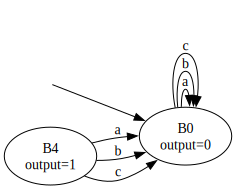

In [10]:
learned_machine_A = MooreMI(io_traces_A, input_alphabet_A, output_alphabet_A, machine_A)

print("La machine a été apprise par MooreMI avec succès.")

learned_machine_A.display_text()
learned_machine_A.visualize('learned_machine_A')


La machine a été apprise par MooreMI avec succès.
Machine de Moore :
États : ['B0']
Entrées : ['a', 'b']
Sorties : ['0', '1']

Sortie par état :
État B0 -> sortie 0

Transitions :
(B0, a) -> B0
(B0, b) -> B0


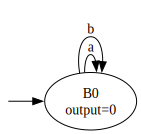

In [11]:
learned_machine_B = MooreMI(io_traces_B, input_alphabet_B, output_alphabet_B, machine_B)

print("La machine a été apprise par MooreMI avec succès.")

learned_machine_B.display_text()
learned_machine_B.visualize('learned_machine_B')


La machine a été apprise par MooreMI avec succès.
Machine de Moore :
États : ['B0', 'B4', 'B5', 'B6']
Entrées : ['a', 'b', 'c']
Sorties : ['0', '1']

Sortie par état :
État B0 -> sortie 0
État B4 -> sortie 0
État B5 -> sortie 1
État B6 -> sortie 1

Transitions :
(B0, a) -> B0
(B0, b) -> B0
(B0, c) -> B0
(B4, a) -> B0
(B4, b) -> B5
(B4, c) -> B6
(B5, a) -> B6
(B5, b) -> B5
(B5, c) -> B0
(B6, a) -> B0
(B6, b) -> B6
(B6, c) -> B4


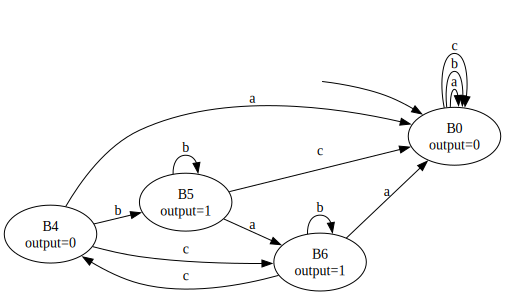

In [12]:
learned_machine_C = MooreMI(io_traces_C, input_alphabet_C, output_alphabet_C, machine_C)

print("La machine a été apprise par MooreMI avec succès.")

learned_machine_C.display_text()
learned_machine_C.visualize('learned_machine_C')


# 6. Comparaison machines A, B, C "apprises par MooreMI" vs "originales"

Après avoir obtenu pour chaque machine originale (A, B, C) une version apprise par MooreMI, il est indispensable de mesurer concrètement leur degré de similarité. Pour cela, nous avons mis en œuvre une fonction `are_equivalent_moore` afin d’évaluer l’équivalence entre les deux. 

**Principe de `are_equivalent_moore`** :  
- La fonction s’appuie sur une exploration parallèle des deux machines, à partir de leurs états initiaux.
- Elle compare les sorties associées à chaque paire d’états visités. Si, à n’importe quel moment, les sorties diffèrent, ou si une entrée mène à deux états produisant des sorties différentes, les machines ne sont pas équivalentes.
- Cette vérification suit une méthode inspirée de la vérification d’équivalence pour les automates finis. Si, au contraire, la fonction parvient à explorer l’ensemble des états accessibles sans trouver de divergence, les deux machines sont considérées équivalentes.

**Critères de réussite** :  
Pour que `are_equivalent_moore` considère deux machines comme équivalentes :  
- Elles doivent partager le même alphabet d’entrée, garantissant que chaque symbole est traité de façon comparable.  
- Leur alphabet de sortie doit être suffisamment compatible pour permettre une comparaison cohérente des sorties. Une différence dans le nombre ou la nature des symboles de sortie est un signe d’incompatibilité (même si, par souci de flexibilité, le code ne s’arrête pas immédiatement sur ce point, il en signale la possibilité).


In [13]:
#Étape 5

def are_equivalent_moore(m1, m2):
    """
    Vérifie l’équivalence de deux machines de Moore minimales.
    Méthode :
    - Commence par comparer l’état initial. Si sorties différentes -> pas équivalentes.
    - BFS sur les paires d’états (q1, q2).
    - Pour chaque paire, compare les sorties. Si différentes -> pas équivalentes.
    - Pour chaque symbole d’entrée, va aux états suivants (q1’, q2’).
      Si sortie différente en q1’ vs q2’, pas équivalentes.
    - Sinon, continuer jusqu’à épuisement.
    - Si aucune différence trouvée, équivalentes.

    Suppositions :
    - m1 et m2 sont minimales, déterministes, complètes, même alphabet d’entrée/sortie.
    """

    # Vérifier que les alphabets sont identiques
    if sorted(m1.input_alphabet) != sorted(m2.input_alphabet):
        print("Différence d’alphabet d’entrée, les machines ne peuvent pas être équivalentes.")
        return False
    if sorted(m1.output_alphabet) != sorted(m2.output_alphabet):
        print("Différence d’alphabet de sortie, les machines peuvent différer.")
        # On peut continuer, car avoir le même ensemble de sorties n’est pas strictement nécessaire pour tester l’équivalence.
        # Mais s’il y a des symboles de sortie absents dans l’une, l’équivalence est douteuse.
        # On continue néanmoins.

    from collections import deque
    visited = set()
    queue = deque()
    # Paire initiale
    start_pair = (m1.initial_state, m2.initial_state)
    queue.append(start_pair)
    visited.add(start_pair)

    while queue:
        q1, q2 = queue.popleft()

        # Vérifier les sorties
        if m1.outputs[q1] != m2.outputs[q2]:
            # Sorties différentes pour le même point de comparaison, pas équivalentes
            return False

        # Tester transitions
        for inp in m1.input_alphabet:
            q1p = m1.transitions[q1][inp]
            q2p = m2.transitions[q2][inp]

            # Vérifier sorties
            if m1.outputs[q1p] != m2.outputs[q2p]:
                return False

            pairp = (q1p, q2p)
            if pairp not in visited:
                visited.add(pairp)
                queue.append(pairp)

    # Aucune différence trouvée
    return True


# Étape 5 : Comparer la machine apprise learned_machine avec la machine originale machine
equivalence_A = are_equivalent_moore(machine_A, learned_machine_A)

if equivalence_A:
    print("La machine apprise est équivalente à la machine originale.")
    print("Ceci démontre que MooreMI a correctement identifié la machine cible, respectant ainsi les conditions de l'article.")
else:
    print("La machine apprise diffère de la machine originale.")
    print("MooreMI n’a pas reproduit fidèlement la machine cible, il peut y avoir un problème dans l’échantillon caractéristique ou l’implémentation.")


Différence d’alphabet de sortie, les machines peuvent différer.
La machine apprise diffère de la machine originale.
MooreMI n’a pas reproduit fidèlement la machine cible, il peut y avoir un problème dans l’échantillon caractéristique ou l’implémentation.


In [14]:
equivalence_B = are_equivalent_moore(machine_B, learned_machine_B)

if equivalence_B:
    print("La machine apprise est équivalente à la machine originale.")
    print("Ceci démontre que MooreMI a correctement identifié la machine cible, respectant ainsi les conditions de l'article.")
else:
    print("La machine apprise diffère de la machine originale.")
    print("MooreMI n’a pas reproduit fidèlement la machine cible, il peut y avoir un problème dans l’échantillon caractéristique ou l’implémentation.")


Différence d’alphabet de sortie, les machines peuvent différer.
La machine apprise diffère de la machine originale.
MooreMI n’a pas reproduit fidèlement la machine cible, il peut y avoir un problème dans l’échantillon caractéristique ou l’implémentation.


In [15]:
equivalence_C = are_equivalent_moore(machine_C, learned_machine_C)

if equivalence_C:
    print("La machine apprise est équivalente à la machine originale.")
    print("Ceci démontre que MooreMI a correctement identifié la machine cible, respectant ainsi les conditions de l'article.")
else:
    print("La machine apprise diffère de la machine originale.")
    print("MooreMI n’a pas reproduit fidèlement la machine cible, il peut y avoir un problème dans l’échantillon caractéristique ou l’implémentation.")


Différence d’alphabet de sortie, les machines peuvent différer.
La machine apprise diffère de la machine originale.
MooreMI n’a pas reproduit fidèlement la machine cible, il peut y avoir un problème dans l’échantillon caractéristique ou l’implémentation.


# 7. Interprétation des résultats  

La fonction signale une différence, qui peut être constaté même facilement d'après la visualisation. Plusieurs hypothèses justificatifs sont possibles :  

  - L’échantillon caractéristique n’était pas correct ou complet, ne permettant pas de distinguer tous les états lors de l’apprentissage.  

  - L’implémentation de MooreMI ou des fonctions auxiliaires (par exemple, le produit PTA, la fusion d’états, la gestion des sorties) n’est pas conforme au pseudo-code de l’article, entraînant des différences structurelles ou comportementales.  
  
  - Les alphabets d’entrée ou de sortie, ou leur codage/décodage, ont été gérés de manière approximative, provoquant une perte d’information et des divergences dans les comportements observés.

En somme, `are_equivalent_moore` fournit un test objectif de l’identification in the limit promise par MooreMI. Les résultats de cette comparaison, lorsqu’ils sont négatifs (machines non équivalentes), incitent à réexaminer l’ensemble de la chaîne d’apprentissage (construction de l’échantillon, mise en œuvre du pseudo-code, traitement des alphabets) afin d’améliorer la fidélité de l’apprentissage.

# 8. Conclusion

Au terme de nos essais, force est de constater que nous n’avons pas réussi à apprendre fidèlement les trois machines (A, B, C) testées :

>Alors même que les conditions semblaient idéales, les machine apprises par MooreMI divergeait lointement des machines cibles, suggérant que des problèmes d’implémentation, de préparation de l’échantillon caractéristique ou d’interprétation du pseudo-code existent dès ce stade.  


Ces échecs ne remettent pas nécessairement en cause la théorie sous-jacente, mais indiquent clairement que **la reproductibilité expérimentale est plus ardue qu’il n’y paraît**. Plusieurs facteurs potentiels ont pu causer ces divergences :

- **Construction et utilisation de l’échantillon caractéristique** : La CSR est une condition délicate. Si l’échantillon n’inclut pas tous les suffixes discriminants, MooreMI ne peut distinguer certains états. Notre préparation de l’échantillon a pu être insuffisante ou erronée.  
- **Interprétation et décodage des sorties** : L’article suppose un certain encodage des sorties en bits. Sans un décodage final correct, la machine apprise reste dans un format binaire partiel, ne retrouvant pas les symboles originaux, et se déforme par rapport à la machine cible.

Cette preuve de concept a mis en évidence les difficultés concrètes de la reproductibilité et appelle à un travail ultérieur pour réconcilier la théorie prometteuse de MooreMI avec une implémentation réellement fonctionnelle dans des conditions pratiques.

>**Enfin, si l’on suppose, par hypothèse, que notre preuve de concept était parfaitement réalisée** — autrement dit, qu’aucune erreur n’a entaché ni l’implémentation ni la construction de l’échantillon caractéristique ni l’interprétation du pseudo-code — **alors** l’échec persistant à reproduire les résultats attendus suggérerait que **la solution proposée par l’article n’est pas reproductible en pratique**. Une telle conclusion serait sévère, mais elle souligne l’importance vitale de la transparence, de la précision et du support opérationnel (code, exemples complets) pour garantir la reproductibilité des méthodes présentées dans la littérature.



